### ACO (Ant Colony Optimization) algorithm for Smart Grids

Intro

In [185]:
interval_num = 24
modes_num = 3
num_nodes = interval_num*modes_num

In [186]:
import networkx as nx
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from statistics import mean

In [187]:
np.seterr(divide='ignore', invalid='ignore')
None

### Generate random X and Y coordinates

In [188]:
xs = []
ys = []
pheromone = []
start_interval = -1
for _ in range(interval_num):
    start_interval += 1
    start_mode = 0
    for _ in range(modes_num):
        xs.append(start_interval)
        ys.append(start_mode)
        pheromone.append(1)
        start_mode += 1
print(xs)
print(ys)
schedule_map = list(zip(xs, ys, pheromone))

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23]
[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]


### Generate the distances between all nodes

### ACO parameters

In [189]:
max_iterations = 100
num_ants = 20

rho = 0.05 # evaporation rate .. this determines how much pheromones are lost at each iteration
alpha = 1 # pheromone exponential parameter
beta = 1 # desirability exponential parameter

### Feasibility Function

In [190]:
cost_table = [300, 0, 0] # Mode 0 is fossil fuel, Mode 1 is battery, Mode 2 is Solar
generation_table = [15, 10, 7]
battery_capacity = 30 # kw/interval
battery_start = battery_capacity # Is battery charged on schedule start?
unit_comsumption = 5 # kw
when_is_solar_available = list(range(5, 18))
solar = 2
battery = 1
fossil_fuel = 0

def is_schedule_viable (actual_schedule):
    battery = battery_capacity
    actual_interval = 0

    # print(f'actual schedule {actual_schedule}')
    for interval_mode in actual_schedule:
        mode = interval_mode
        if generation_table[mode] < unit_comsumption:
            return False
        elif mode == solar:
            if actual_interval not in when_is_solar_available:
                return False
            else:
                battery += generation_table[mode]-unit_comsumption
        elif mode == battery:
            if unit_comsumption > battery:
                return False
            else:
                battery += -unit_comsumption
        elif mode == fossil_fuel:
            battery += generation_table[mode]-unit_comsumption
            if battery > battery_capacity:
                battery = battery_capacity
        actual_interval += 1
    
    return True


### ACO functions

In [191]:
def create_colony(num_ants):
    current_schedule_all = []
    for i in range(num_ants):
        current_schedule = []
        
        actual_interval = 0
        impossible_modes = []
        while actual_interval < interval_num:
            # print(f'{actual_interval} intervals')
            possible_schedules = []
            possible_schedules_weight = []
            for modes in schedule_map:
                if modes[0] == actual_interval and modes[1] not in impossible_modes:
                    possible_schedules.append(modes[1])
                    possible_schedules_weight.append(modes[2])
            if possible_schedules == []:
                impossible_modes = []
                actual_interval += -1
                current_schedule.pop()
            else:
                chosen_schedule = random.choices(possible_schedules, possible_schedules_weight)
                trial_schedule = current_schedule.copy()
                trial_schedule.append(chosen_schedule[0])
                # print(f' trial {trial_schedule}')
                viable = is_schedule_viable(trial_schedule)
                # print(viable)
                if viable:
                    chosen_schedule = trial_schedule
                    impossible_modes = []
                    current_schedule = trial_schedule
                    actual_interval += 1
                else:
                    impossible_modes.append(chosen_schedule[0])
        
        current_schedule_all.append(current_schedule)
    
    return current_schedule_all
 

### Main loop of ACO

In [192]:
shortest_tour_length = float('inf')
all_solutions = np.empty((0, 2))
lowestCostValues = []

for i in range(0, max_iterations):
    # create the tours for all ants
    tours = create_colony(num_ants)

    # calculate the tour length for each tour
    tour_lengths = []
    for schedule in tours:
        total_cost = 0
        for interval_mode_tour in schedule:
            # print(interval_mode_tour)
            total_cost += cost_table[interval_mode_tour]
        # print(total_cost)
        if total_cost <= shortest_tour_length:
            shortest_tour_length = total_cost
            best_tour = schedule
        tour_lengths.append(total_cost)
        tour_and_distance = list(zip((tours, tour_lengths)))
    print(f'shortest tour {best_tour}')
    print(f'length {shortest_tour_length}')
    lowestCostValues.append(shortest_tour_length)
        
    # update the pheromone matrix and evaporate
    interval_start = 0
    for interval in best_tour:
        for intervals in schedule_map:
            if intervals[0] == interval_start and intervals[1] == interval:
                intervals = (intervals[0], intervals[1], intervals[2]+alpha) 
            intervals = (intervals[0], intervals[1], intervals[2]*(1-rho))
        interval_start += 1


shortest tour [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0]
length 1500
shortest tour [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0]
length 1500
shortest tour [1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 1, 0]
length 1500
shortest tour [1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 1, 0]
length 1500
shortest tour [1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 1, 0]
length 1500
shortest tour [1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1]
length 900
shortest tour [1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1]
length 900
shortest tour [1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1]
length 900
shortest tour [1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1]
length 900
shortest tour [1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1]
length 900
shortest tour [

### Plot

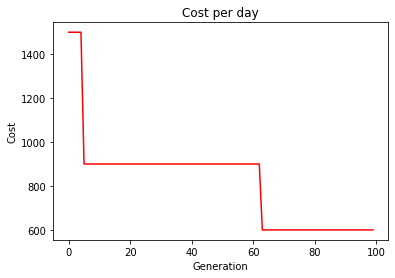

In [193]:
plt.plot(lowestCostValues, color='red')
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.title('Cost per day')
plt.show()
